In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, roc_curve
)
import xgboost as xgb
import seaborn as sns
import pickle

In [21]:
df = pd.read_csv("../data/processed/qqq_features_classification.csv",
                 index_col="Date",
                 parse_dates=["Date"])

df.head()

,Open,High,Low,Close,Volume,ATR14,returns,vol_std20,norm_tr,vol_ratio,roc5,rsi10,candle_body_pct,vol_ma20,vol_spike,return_1d,return_3d,return_5d,future_3d_return,target
Date,,,,,,,,,,,,,,,,,,,,
1999-04-08,54.93750,55.734375,53.812500,47.230087,7952400,8.781853,0.007950,0.022590,0.040692,388.749281,0.057177,76.058700,4.010361,7331370.0,1.084709,0.007950,-0.000563,0.057177,-0.014085,0
1999-04-09,55.37500,55.937500,55.218750,47.522800,4946800,8.797062,0.006198,0.022593,0.015124,389.363698,0.042007,71.621792,10.924799,7094280.0,0.697294,0.006198,0.003653,0.042007,-0.053752,0
1999-04-12,54.50000,55.812500,54.437500,47.203495,10934000,8.821242,-0.006719,0.021737,0.029129,405.808671,-0.001126,73.320225,5.306549,7203800.0,1.517810,-0.006719,0.007382,-0.001126,-0.034386,0
1999-04-13,55.78125,55.906250,54.250000,46.564873,9962200,8.912809,-0.013529,0.021396,0.035569,416.566479,-0.016578,57.834057,5.564605,7383460.0,1.349259,-0.013529,-0.014085,-0.016578,-0.049714,0
1999-04-14,55.37500,55.437500,52.507812,44.968361,21253800,8.908173,-0.034286,0.022925,0.065150,388.579719,-0.040318,47.358470,3.552133,8200860.0,2.591655,-0.034286,-0.053752,-0.040318,-0.062130,0


Define Features and Target

In [22]:
target_col = "target"

feature_cols = [
    "ATR14",
    "vol_std20",
    "norm_tr",
    "vol_ratio",
    "roc5",
    "rsi10",
    "candle_body_pct",
    "vol_spike",
    "return_1d",
    "return_3d",
    "return_5d"
]

X = df[feature_cols]
y = df[target_col]


In [23]:
# Time Series
train_df = df.loc["1999":"2018"]
test_df  = df.loc["2019":]

X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_test  = test_df[feature_cols]
y_test  = test_df[target_col]

In [24]:
X_train.shape, X_test.shape


((4966, 11), (1726, 11))

XGBoost 

In [25]:
model = xgb.XGBClassifier(
    max_depth=4,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss"
)

model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


Predictions

In [26]:
pred_prob = model.predict_proba(X_test)[:, 1]   # probability of UP
pred_label = (pred_prob > 0.5).astype(int)

Evaluations

In [27]:
print("Accuracy:", accuracy_score(y_test, pred_label))
print("Precision:", precision_score(y_test, pred_label))
print("Recall:", recall_score(y_test, pred_label))
print("F1 Score:", f1_score(y_test, pred_label))
print("AUC:", roc_auc_score(y_test, pred_prob))

Accuracy: 0.5428736964078795
Precision: 0.5807142857142857
Recall: 0.8009852216748768
F1 Score: 0.6732919254658385
AUC: 0.511475546132901


Confusion Matrix

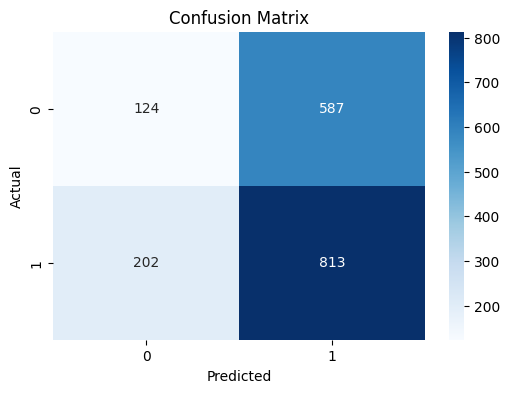

In [28]:
cm = confusion_matrix(y_test, pred_label)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


ROC Curve

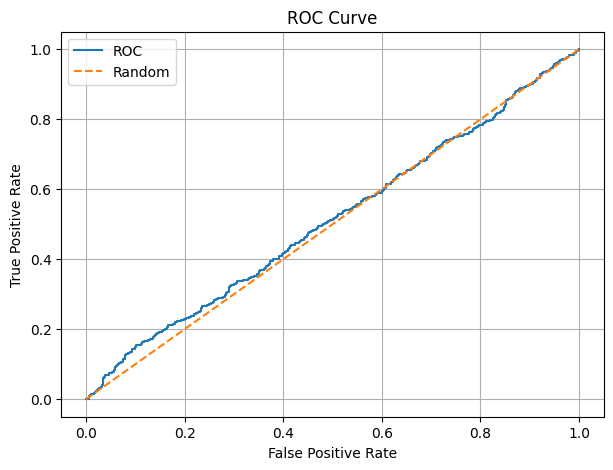

In [29]:
fpr, tpr, _ = roc_curve(y_test, pred_prob)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label="ROC")
plt.plot([0, 1], [0, 1], "--", label="Random")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

Feature Importance

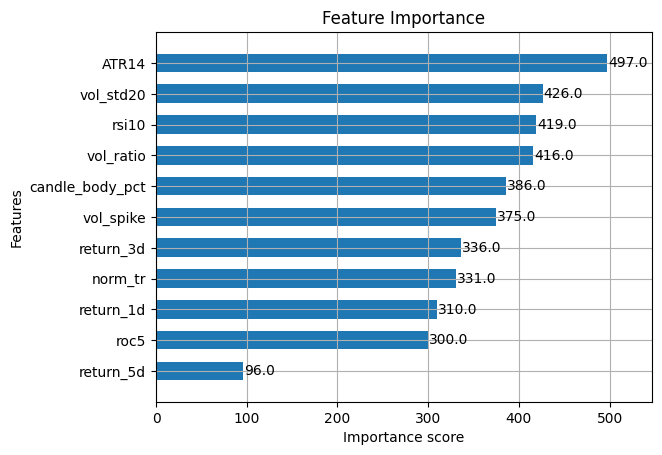

In [30]:
xgb.plot_importance(model, max_num_features=12, height=0.6)
plt.title("Feature Importance")
plt.show()


My Interpretation:
1. Model predict almost everything up,heavily bias
2. High recall, low precision
3. AUC = 0.51, the model does not have real edge

-It may due to period of the indicator being used, my plan is to reduce the period of the indicator used to 3-7 days.

-Or maybe can add directional indicator like Moving Average 5 or 10

-Maybe can use ROC 2 to capture short term directional bias
